<a href="https://colab.research.google.com/github/davkeem/SHAZAM-CAPSTONE/blob/main/final_model_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
import os


drive.mount('/content/drive')

hist_data_folder = '/content/drive/My Drive/SHAZAM-CAPSTONE-main/SHAZAM-CAPSTONE-main/hist_data'


chroma_data_folder = '/content/drive/My Drive/SHAZAM-CAPSTONE-main/SHAZAM-CAPSTONE-main/dataset_processed/processed_chroma/ml_processed_data'
harmonic_data_folder ='/content/drive/My Drive/SHAZAM-CAPSTONE-main/SHAZAM-CAPSTONE-main/dataset_processed/processed_harmonic/ml_processed_data'
mfcc_data_folder = '/content/drive/My Drive/SHAZAM-CAPSTONE-main/SHAZAM-CAPSTONE-main/mfcc'
onset_data_folder = '/content/drive/My Drive/SHAZAM-CAPSTONE-main/SHAZAM-CAPSTONE-main/dataset_processed/processed_onset/ml_processed_data'
percussive_data_folder = '/content/drive/My Drive/SHAZAM-CAPSTONE-main/SHAZAM-CAPSTONE-main/dataset_processed/processed_percussive/ml_processed_data'
spectral_centroid_data_folder = '/content/drive/My Drive/SHAZAM-CAPSTONE-main/SHAZAM-CAPSTONE-main/dataset_processed/processed_spectral_centroid/ml_processed_data'
spectral_contrast_data_folder = '/content/drive/My Drive/SHAZAM-CAPSTONE-main/SHAZAM-CAPSTONE-main/dataset_processed/processed_spectral_contrast/ml_processed_data'
tempo_beats_data_folder = '/content/drive/My Drive/SHAZAM-CAPSTONE-main/SHAZAM-CAPSTONE-main/dataset_processed/processed_tempo_beats/ml_processed_data'


Mounted at /content/drive


In [2]:
import os
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.sequence import pad_sequences

def load_data(directory):
    data = []
    for file_name in sorted(os.listdir(directory)):
        if file_name.endswith('.csv'):
            file_path = os.path.join(directory, file_name)
            df = pd.read_csv(file_path, header=None, skiprows=1)
            # Clean the data to remove brackets and convert to float
            df = df.replace(r'[\[\]]', '', regex=True).astype(float) #Tempo beats data has brackets
            data.append(df.iloc[:, 1:].values)  # Exclude the time bin column
    max_length = max(array.shape[0] for array in data)  # Find the max length
    padded_data = pad_sequences(data, maxlen=max_length, padding='post', dtype='float32')  # Pad sequences
    return np.array(padded_data)

# Load data from all specified folders
mfcc_data = load_data(mfcc_data_folder)
hist_data = load_data(hist_data_folder)
chroma_data = load_data(chroma_data_folder)
harmonic_data = load_data(harmonic_data_folder)
onset_data = load_data(onset_data_folder)
percussive_data = load_data(percussive_data_folder)
spectral_centroid_data = load_data(spectral_centroid_data_folder)
spectral_contrast_data = load_data(spectral_contrast_data_folder)
tempo_beats_data = load_data(tempo_beats_data_folder)

# Combine all features into X for the ablation study
all_features = {
    "mfcc": mfcc_data,
    "chroma": chroma_data,
    "harmonic": harmonic_data,
    "onset": onset_data,
    "percussive": percussive_data,
    "spectral_centroid": spectral_centroid_data,
    "spectral_contrast": spectral_contrast_data,
    "tempo_beats": tempo_beats_data,
}

# Concatenate all features into a single array
X = np.concatenate(list(all_features.values()), axis=2)  # Combine along feature axis
y = hist_data

print(f"X shape: {X.shape}")  # Combined features
print(f"y shape: {y.shape}")  # Target histogram





X shape: (20, 550, 70)
y shape: (20, 550, 1)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import LeaveOneOut
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, Masking
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K

from sklearn.model_selection import train_test_split
from statistics import mean, stdev

# Dictionary to store ablation study results
ablation_results = {}

# Number of repetitions for averaging
num_repeats = 10

# Iterate over each feature set
for feature_name, feature_data in all_features.items():
    print(f"Evaluating feature: {feature_name}")
    losses = []  # Store losses for all repetitions

    for repeat in range(num_repeats):
        print(f"  Repetition {repeat + 1}/{num_repeats}")

        # Use only the current feature for training
        X_feature = feature_data

        # Split into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(X_feature, y, test_size=0.2, random_state=repeat)

        # Define the model
        model = Sequential()
        model.add(Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
        model.add(MaxPooling1D(pool_size=2))
        model.add(Dropout(0.3))
        model.add(Conv1D(128, kernel_size=3, activation='relu'))
        model.add(MaxPooling1D(pool_size=2))
        model.add(Dropout(0.3))
        model.add(Flatten())
        model.add(Dense(X_train.shape[1], activation='linear'))
        model.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_squared_error')

        # Train the model
        model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)  # Verbose=0 for cleaner output

        # Evaluate the model
        loss = model.evaluate(X_test, y_test, verbose=0)
        losses.append(loss)

    # Store the average and standard deviation of losses
    avg_loss = mean(losses)
    std_loss = stdev(losses)
    ablation_results[feature_name] = (avg_loss, std_loss)
    print(f"Feature: {feature_name} - Avg Test MSE: {avg_loss:.4f} ± {std_loss:.4f}")


Evaluating feature: mfcc
  Repetition 1/10
  Repetition 2/10
  Repetition 3/10
  Repetition 4/10
  Repetition 5/10
  Repetition 6/10
  Repetition 7/10
  Repetition 8/10
  Repetition 9/10
  Repetition 10/10
Feature: mfcc - Avg Test MSE: 2299650.6500 ± 302373.3048
Evaluating feature: chroma
  Repetition 1/10
  Repetition 2/10
  Repetition 3/10
  Repetition 4/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:934: UserWarning: Layer 'conv1d_6' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Fold 1: Leaving out song at index 0
Epoch 1/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 8492953.0000
Epoch 2/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step - loss: 6211555.5000
Epoch 3/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step - loss: 4563038.5000
Epoch 4/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - loss: 3376367.5000
Epoch 5/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step - loss: 2651861.0000
Epoch 6/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step - loss: 2177982.7500
Epoch 7/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step - loss: 1941369.0000
Epoch 8/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step - loss: 1844045.6250
Epoch 9/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step - loss: 1832479.7500
Epoch 10/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step - loss: 1766745.6250
Epoch 11/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step - loss: 1784192.2500
Epoch 12/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step - loss: 1734689.0000
Epoch 13/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - loss: 1721086.3750
Epoch 14/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

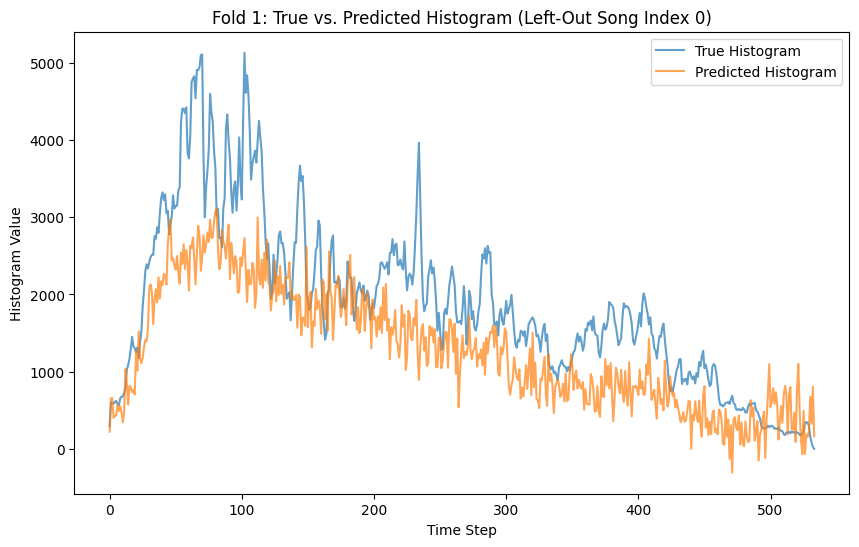

Fold 2: Leaving out song at index 1
Epoch 1/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step - loss: 1015644.3125
Epoch 2/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step - loss: 1021286.5000
Epoch 3/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step - loss: 1040854.1250
Epoch 4/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 640ms/step - loss: 981454.0000
Epoch 5/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step - loss: 977472.8125
Epoch 6/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step - loss: 955629.2500
Epoch 7/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 712ms/step - loss: 944321.1875
Epoch 8/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 529ms/step - loss: 938794.9375
Epoch 9/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 487ms/step - loss: 922922.0000
Epoch 10/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step - loss: 916450.7500
Epoch 11/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step - loss: 898217.1875
Epoch 12/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step - loss: 892814.1250
Epoch 13/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step - loss: 888985.8750
Epoch 14/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/s

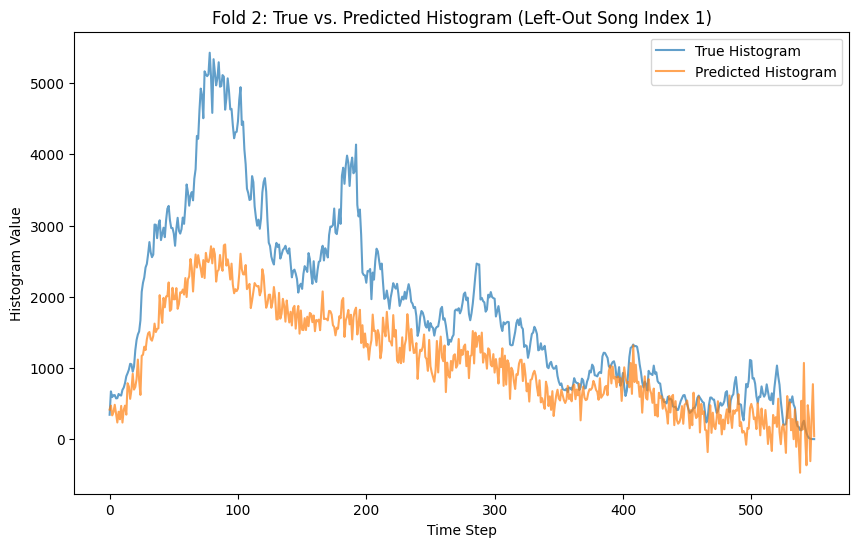

Fold 3: Leaving out song at index 2
Epoch 1/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - loss: 691640.0000
Epoch 2/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step - loss: 678921.9375
Epoch 3/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step - loss: 666151.7500
Epoch 4/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step - loss: 659746.6250
Epoch 5/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step - loss: 653445.5625
Epoch 6/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step - loss: 641923.9375
Epoch 7/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step - loss: 610253.2500
Epoch 8/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - loss: 632982.9375
Epoch 9/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step - loss: 611315.3125
Epoch 10/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step - loss: 620735.3750
Epoch 11/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step - loss: 613350.1875
Epoch 12/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step - loss: 619517.5000
Test MSE for this fold: 1391605.625
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Test RMSE for this fold: 1179.663330078125


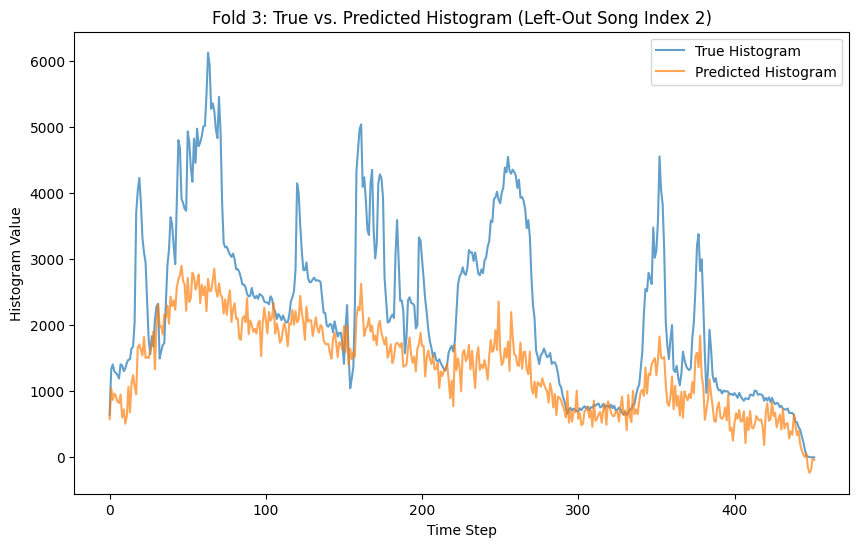

Fold 4: Leaving out song at index 3
Epoch 1/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step - loss: 608790.1250
Epoch 2/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 551ms/step - loss: 596230.0625
Epoch 3/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step - loss: 614299.3125
Epoch 4/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step - loss: 583677.8125
Epoch 5/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 632ms/step - loss: 568074.7500
Epoch 6/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 614ms/step - loss: 566918.2500
Epoch 7/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step - loss: 570573.0000
Epoch 8/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step - loss: 555465.5000
Epoch 9/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step - loss: 545298.8750
Epoch 10/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step - loss: 553842.1875
Epoch 11/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step - loss: 532651.1875
Epoch 12/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step - loss: 522273.0938
Epoch 13/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step - loss: 526868.9375
Epoch 14/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step

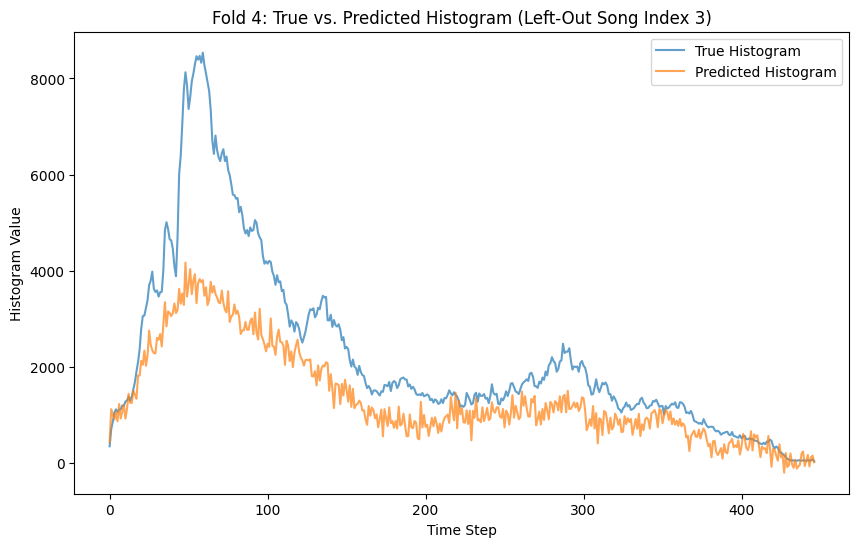

Fold 5: Leaving out song at index 4
Epoch 1/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - loss: 455129.2500
Epoch 2/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step - loss: 440803.6875
Epoch 3/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step - loss: 457753.0000
Epoch 4/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step - loss: 444411.0625
Epoch 5/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step - loss: 442577.0938
Epoch 6/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step - loss: 433685.4375
Epoch 7/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step - loss: 447837.0625
Epoch 8/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step - loss: 452549.9062
Epoch 9/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - loss: 440673.8438
Epoch 10/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step - loss: 407103.6562
Epoch 11/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step - loss: 424873.5312
Epoch 12/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step - loss: 419366.0625
Epoch 13/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step - loss: 411064.6562
Epoch 14/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step

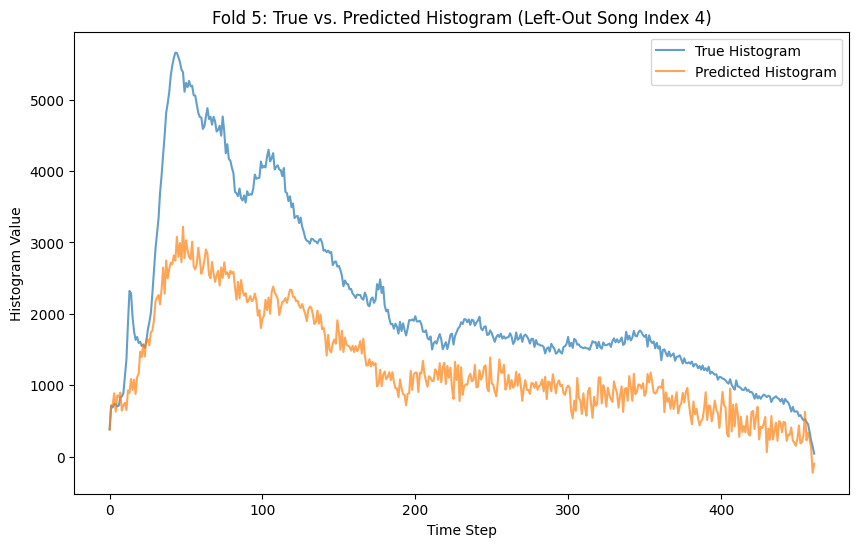

Fold 6: Leaving out song at index 5
Epoch 1/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step - loss: 360883.0625
Epoch 2/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step - loss: 349582.3750
Epoch 3/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step - loss: 357003.1562
Epoch 4/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step - loss: 336800.7500
Epoch 5/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step - loss: 345522.1562
Epoch 6/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step - loss: 343277.8438
Epoch 7/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 551ms/step - loss: 317337.1562
Epoch 8/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step - loss: 325149.5312
Epoch 9/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step - loss: 335886.7812
Epoch 10/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step - loss: 334593.7500
Epoch 11/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - loss: 312953.9688
Epoch 12/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step - loss: 322361.5625
Epoch 13/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step - loss: 320722.6250
Epoch 14/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step

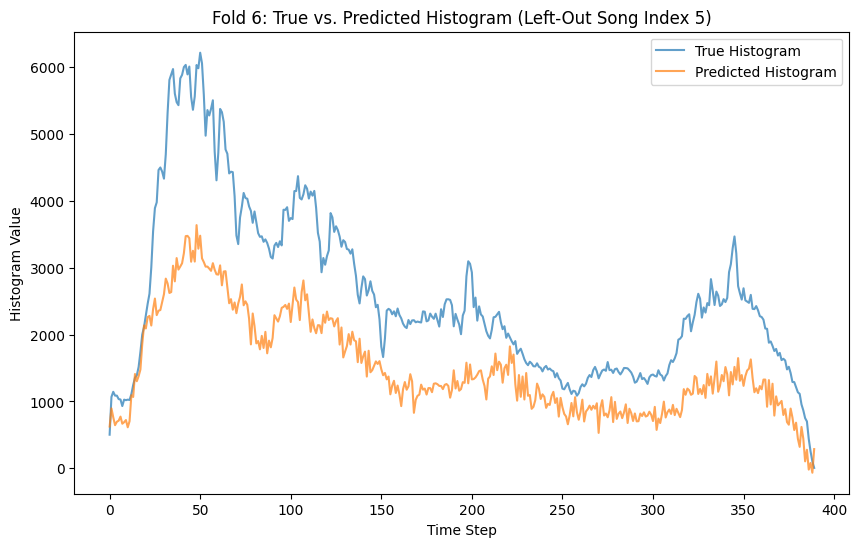

Fold 7: Leaving out song at index 6
Epoch 1/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step - loss: 303723.2812
Epoch 2/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step - loss: 297395.8125
Epoch 3/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step - loss: 304369.3125
Epoch 4/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 673ms/step - loss: 298018.4375
Epoch 5/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 575ms/step - loss: 299156.4062
Epoch 6/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step - loss: 301491.7188
Epoch 7/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step - loss: 282607.9375
Epoch 8/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step - loss: 293429.4375
Epoch 9/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step - loss: 295726.6875
Epoch 10/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 702ms/step - loss: 297486.1250
Epoch 11/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step - loss: 288231.8438
Epoch 12/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 537ms/step - loss: 282648.6562
Test MSE for this fold: 1029359.3125
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Test RMSE for this fold: 1014.5735473632812


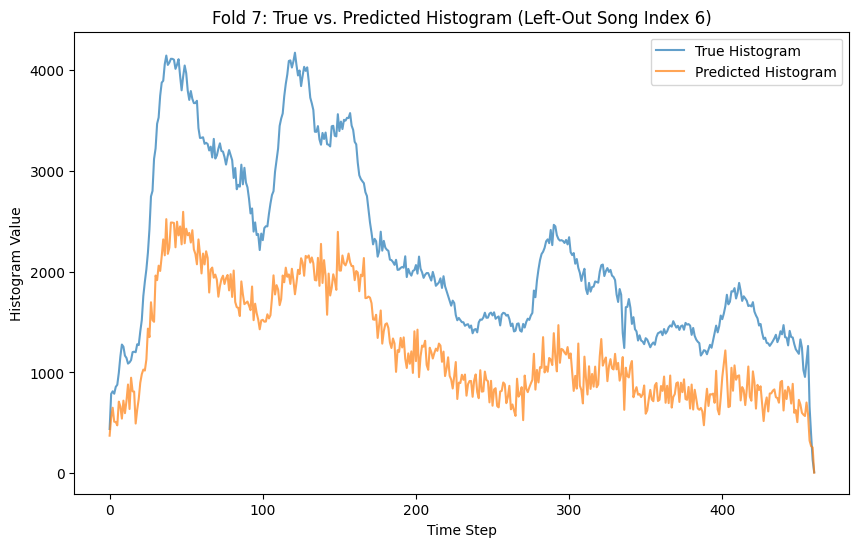

Fold 8: Leaving out song at index 7
Epoch 1/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step - loss: 272550.3750
Epoch 2/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step - loss: 278239.1562
Epoch 3/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - loss: 267374.6250
Epoch 4/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step - loss: 262460.5938
Epoch 5/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step - loss: 263243.8125
Epoch 6/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step - loss: 260119.5469
Epoch 7/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - loss: 252212.2656
Epoch 8/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step - loss: 258652.4688
Epoch 9/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step - loss: 248574.9219
Epoch 10/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step - loss: 256901.1094
Epoch 11/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step - loss: 252114.6094
Epoch 12/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - loss: 246330.8125
Epoch 13/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step - loss: 244315.6875
Epoch 14/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step

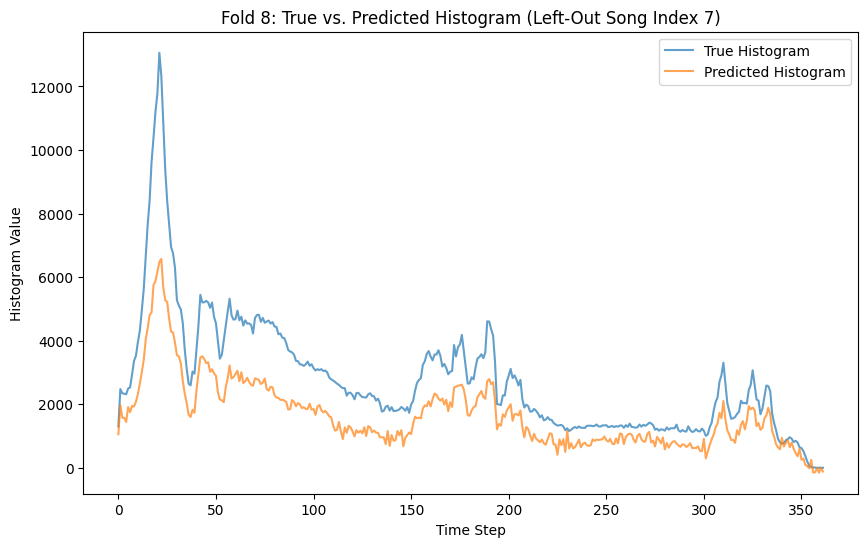

Fold 9: Leaving out song at index 8
Epoch 1/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step - loss: 235159.2969
Epoch 2/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step - loss: 231299.0000
Epoch 3/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 719ms/step - loss: 220284.7344
Epoch 4/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 583ms/step - loss: 226404.1094
Epoch 5/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 609ms/step - loss: 221020.0312
Epoch 6/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 487ms/step - loss: 223918.6875
Epoch 7/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 566ms/step - loss: 213521.1406
Epoch 8/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 635ms/step - loss: 217864.0938
Epoch 9/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 635ms/step - loss: 228545.5000
Epoch 10/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step - loss: 217094.8281
Epoch 11/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step - loss: 229668.3750
Epoch 12/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step - loss: 214629.1406
Test MSE for this fold: 1059020.75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Test RMSE for this fold: 1029.0872802734375


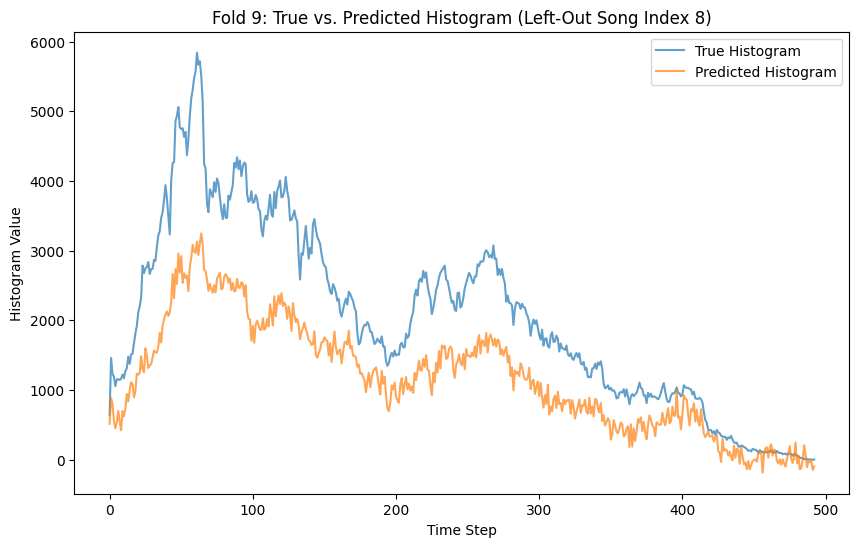

Fold 10: Leaving out song at index 9
Epoch 1/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step - loss: 207427.8594
Epoch 2/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - loss: 211525.3281
Epoch 3/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step - loss: 208348.6094
Epoch 4/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step - loss: 204435.6094
Epoch 5/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step - loss: 199189.8281
Epoch 6/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - loss: 197899.1562
Epoch 7/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step - loss: 206578.3125
Epoch 8/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - loss: 208145.2969
Epoch 9/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step - loss: 193181.6250
Epoch 10/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - loss: 193772.2969
Epoch 11/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step - loss: 200559.0469
Epoch 12/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 569ms/step - loss: 192134.0469
Epoch 13/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - loss: 194348.5781
Epoch 14/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/ste

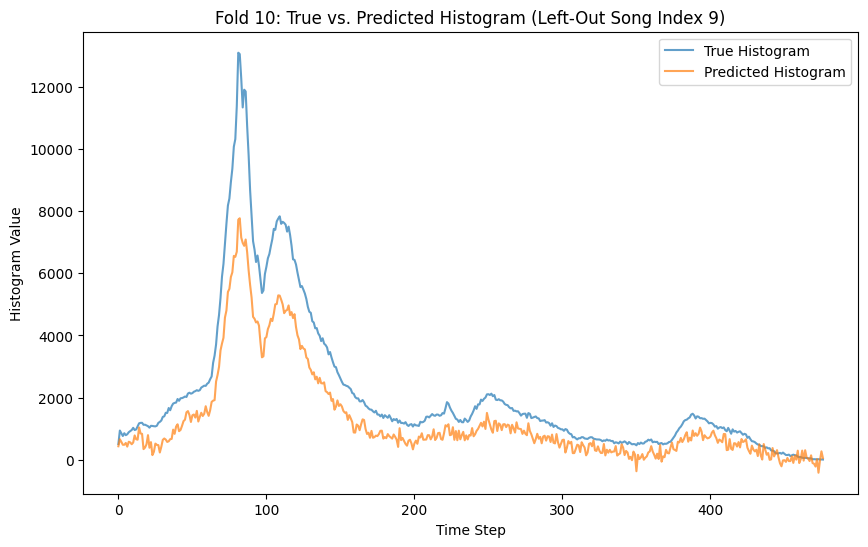

Fold 11: Leaving out song at index 10
Epoch 1/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step - loss: 179219.0000
Epoch 2/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step - loss: 183000.1562
Epoch 3/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 500ms/step - loss: 178878.9375
Epoch 4/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 598ms/step - loss: 180399.7812
Epoch 5/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 494ms/step - loss: 174157.4219
Epoch 6/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 558ms/step - loss: 181733.0156
Epoch 7/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step - loss: 177267.7812
Epoch 8/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 703ms/step - loss: 176720.3594
Epoch 9/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 478ms/step - loss: 176326.7344
Epoch 10/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step - loss: 171466.2656
Epoch 11/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step - loss: 178119.7656
Epoch 12/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - loss: 173194.6875
Epoch 13/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step - loss: 171998.0469
Epoch 14/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/st

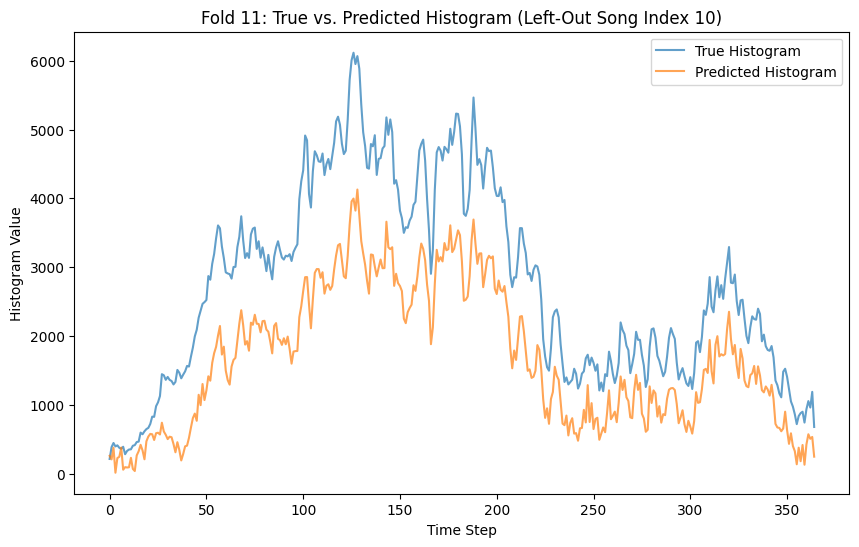

Fold 12: Leaving out song at index 11
Epoch 1/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step - loss: 161546.3281
Epoch 2/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step - loss: 161959.7969
Epoch 3/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step - loss: 153643.4688
Epoch 4/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step - loss: 159269.4531
Epoch 5/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step - loss: 166980.5312
Epoch 6/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step - loss: 148889.1094
Epoch 7/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step - loss: 153504.2031
Epoch 8/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step - loss: 156442.7812
Epoch 9/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step - loss: 155084.4688
Epoch 10/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step - loss: 152935.4375
Epoch 11/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step - loss: 152472.3750
Test MSE for this fold: 1159221.125
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Test RMSE for this fold: 1076.67138671875


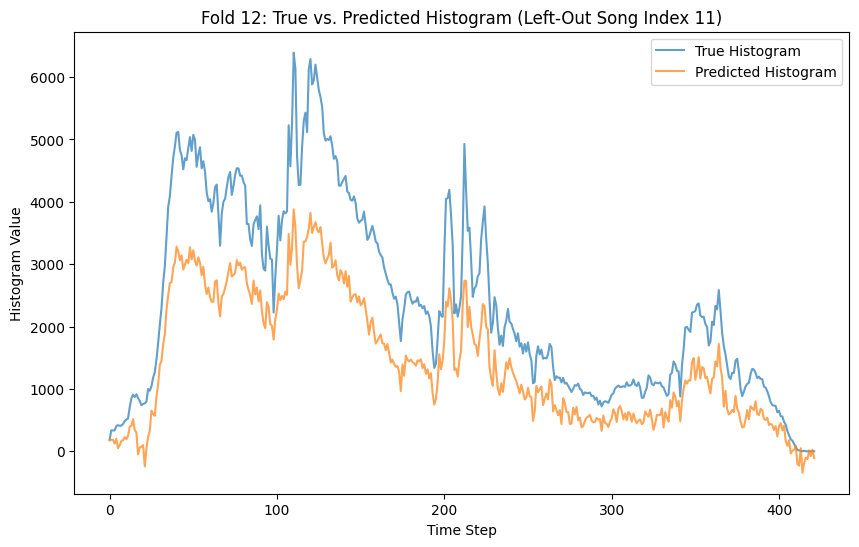

Fold 13: Leaving out song at index 12
Epoch 1/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step - loss: 157251.8125
Epoch 2/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step - loss: 155890.0625
Epoch 3/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step - loss: 156109.6094
Epoch 4/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 661ms/step - loss: 148573.1562
Epoch 5/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 632ms/step - loss: 145904.9844
Epoch 6/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step - loss: 154515.9375
Epoch 7/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step - loss: 147016.9219
Epoch 8/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 534ms/step - loss: 147751.4375
Epoch 9/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 638ms/step - loss: 147013.7500
Epoch 10/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 487ms/step - loss: 150312.5312
Test MSE for this fold: 969163.625
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Test RMSE for this fold: 984.4609985351562


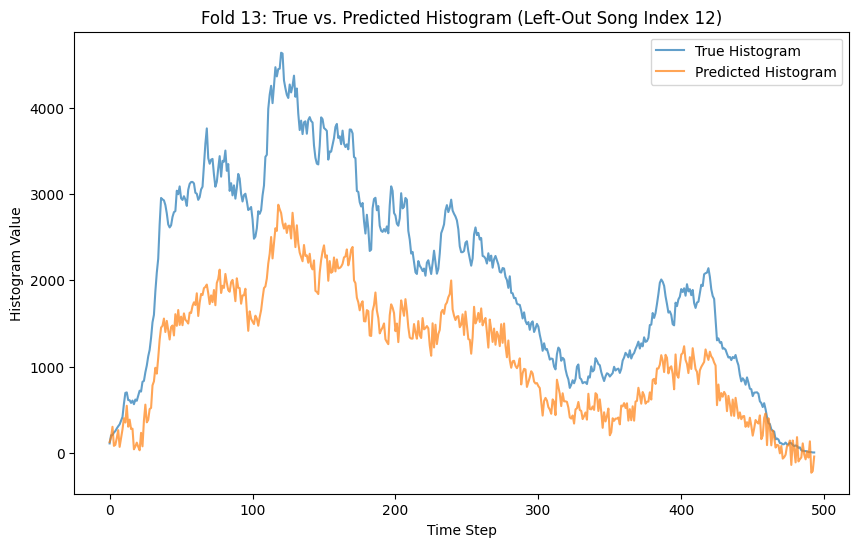

Fold 14: Leaving out song at index 13
Epoch 1/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step - loss: 152098.9844
Epoch 2/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step - loss: 152843.0469
Epoch 3/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step - loss: 145921.2656
Epoch 4/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step - loss: 141351.7969
Epoch 5/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step - loss: 142193.3906
Epoch 6/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step - loss: 141094.1562
Epoch 7/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step - loss: 146834.2812
Epoch 8/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step - loss: 145929.5000
Epoch 9/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step - loss: 141380.6406
Epoch 10/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step - loss: 147960.0938
Epoch 11/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - loss: 147827.1719
Test MSE for this fold: 1027829.9375
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Test RMSE for this fold: 1013.8194580078125


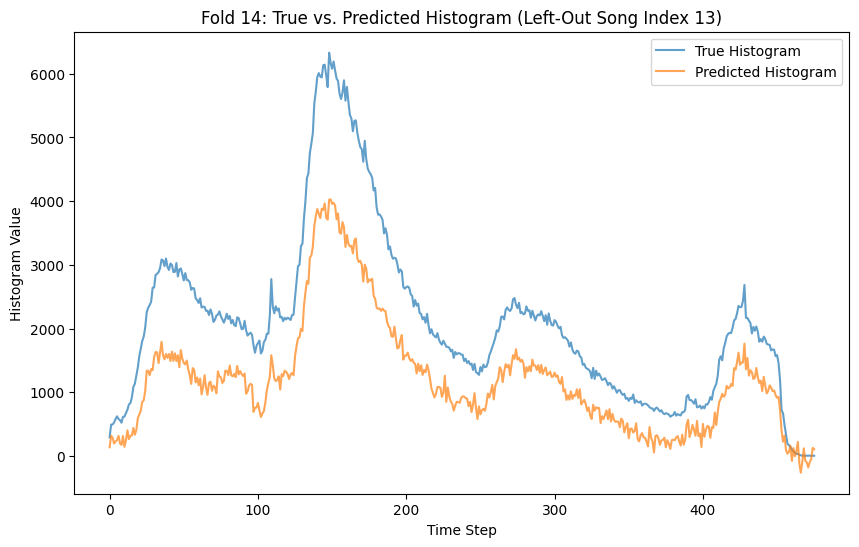

Fold 15: Leaving out song at index 14
Epoch 1/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step - loss: 140293.6250
Epoch 2/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step - loss: 136039.2812
Epoch 3/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step - loss: 133323.0938
Epoch 4/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step - loss: 137782.7344
Epoch 5/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step - loss: 136988.7031
Epoch 6/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step - loss: 135911.5781
Epoch 7/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step - loss: 135463.3594
Epoch 8/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step - loss: 137902.2812
Test MSE for this fold: 1785608.125
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Test RMSE for this fold: 1336.2664794921875


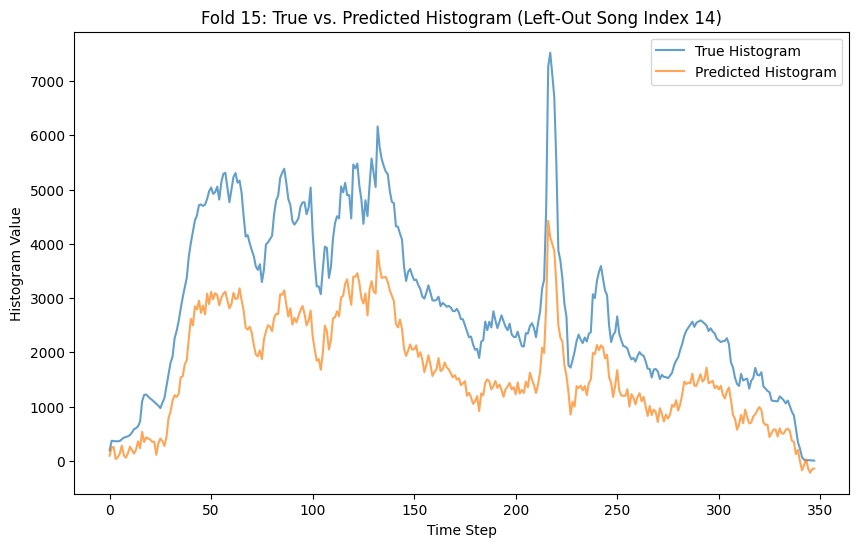

Fold 16: Leaving out song at index 15
Epoch 1/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step - loss: 133187.1562
Epoch 2/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step - loss: 136732.4531
Epoch 3/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step - loss: 134651.2500
Epoch 4/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step - loss: 130179.8438
Epoch 5/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step - loss: 127449.0000
Epoch 6/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step - loss: 133323.7500
Epoch 7/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step - loss: 132422.1250
Epoch 8/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - loss: 137675.8281
Epoch 9/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step - loss: 130323.2734
Epoch 10/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step - loss: 123339.6328
Epoch 11/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step - loss: 126559.6875
Epoch 12/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step - loss: 125983.2891
Epoch 13/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 615ms/step - loss: 124568.4453
Epoch 14/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/st

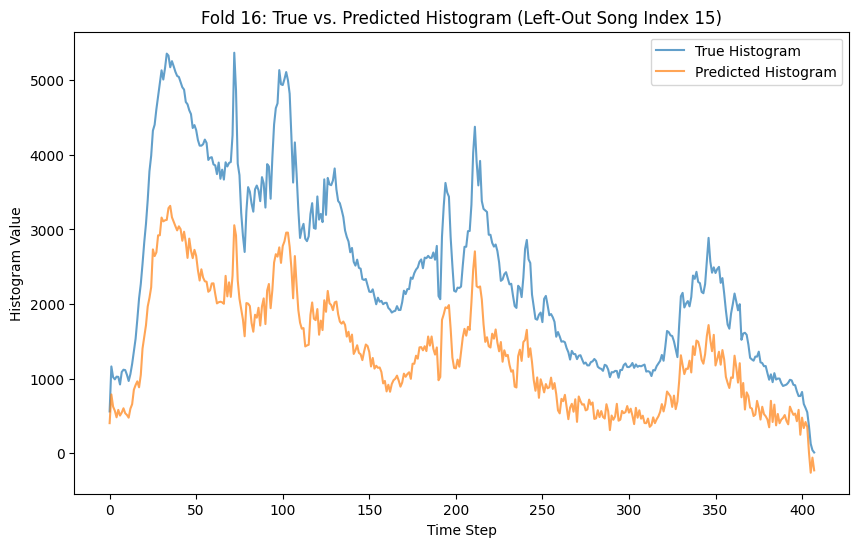

Fold 17: Leaving out song at index 16
Epoch 1/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step - loss: 128594.3828
Epoch 2/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step - loss: 127735.8672
Epoch 3/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step - loss: 128350.2500
Epoch 4/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 503ms/step - loss: 126288.1953
Epoch 5/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 584ms/step - loss: 124569.0781
Epoch 6/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step - loss: 119945.5156
Epoch 7/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step - loss: 123365.8516
Epoch 8/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step - loss: 119544.8984
Epoch 9/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step - loss: 122558.5156
Epoch 10/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step - loss: 120239.5781
Epoch 11/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - loss: 121860.3281
Epoch 12/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - loss: 123184.1016
Epoch 13/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step - loss: 116804.6016
Epoch 14/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/st

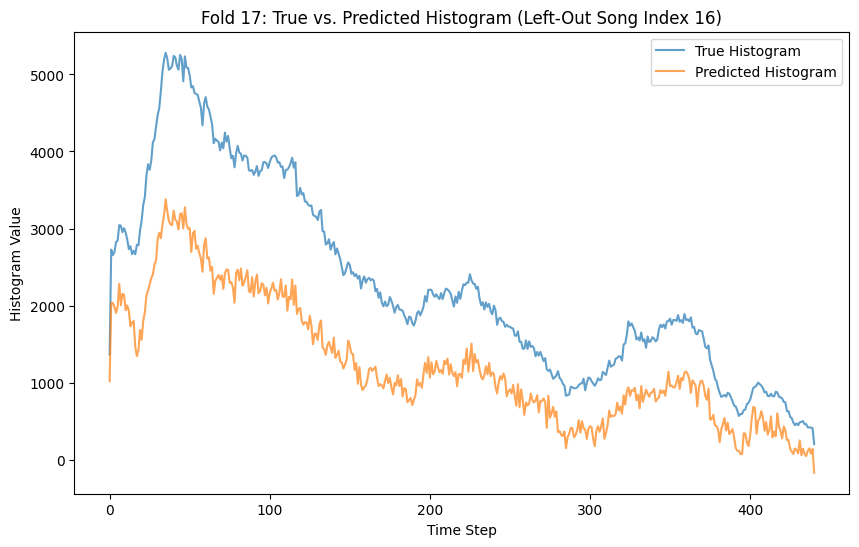

Fold 18: Leaving out song at index 17
Epoch 1/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step - loss: 117118.5938
Epoch 2/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step - loss: 118790.6562
Epoch 3/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step - loss: 122673.1328
Epoch 4/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step - loss: 112652.4766
Epoch 5/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - loss: 122504.5391
Epoch 6/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step - loss: 118653.5234
Epoch 7/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step - loss: 121257.7266
Epoch 8/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step - loss: 116557.0938
Epoch 9/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step - loss: 115576.2266
Test MSE for this fold: 985174.5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Test RMSE for this fold: 992.5596313476562


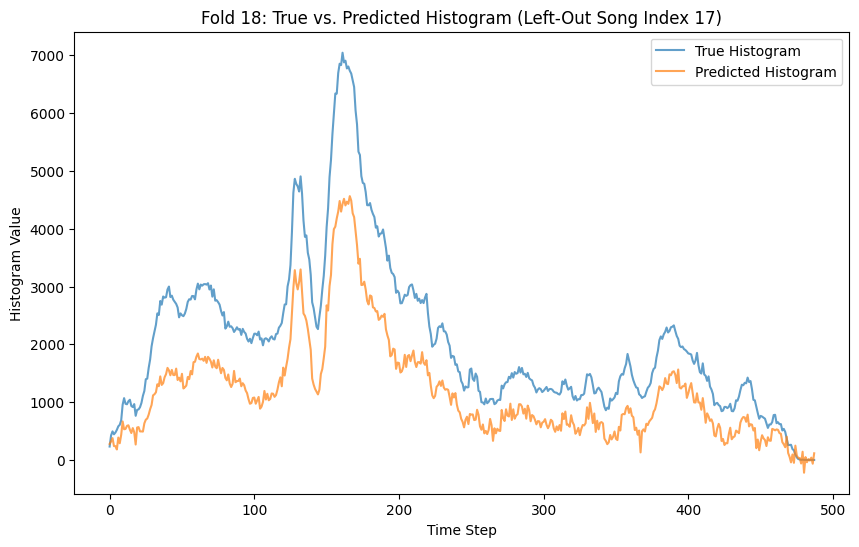

Fold 19: Leaving out song at index 18
Epoch 1/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step - loss: 112966.5000
Epoch 2/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step - loss: 111692.5000
Epoch 3/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step - loss: 111606.2500
Epoch 4/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step - loss: 112219.8438
Epoch 5/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step - loss: 114395.5156
Epoch 6/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step - loss: 116893.2656
Epoch 7/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step - loss: 112936.7266
Epoch 8/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step - loss: 112493.4453
Test MSE for this fold: 1439623.0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Test RMSE for this fold: 1199.8428955078125


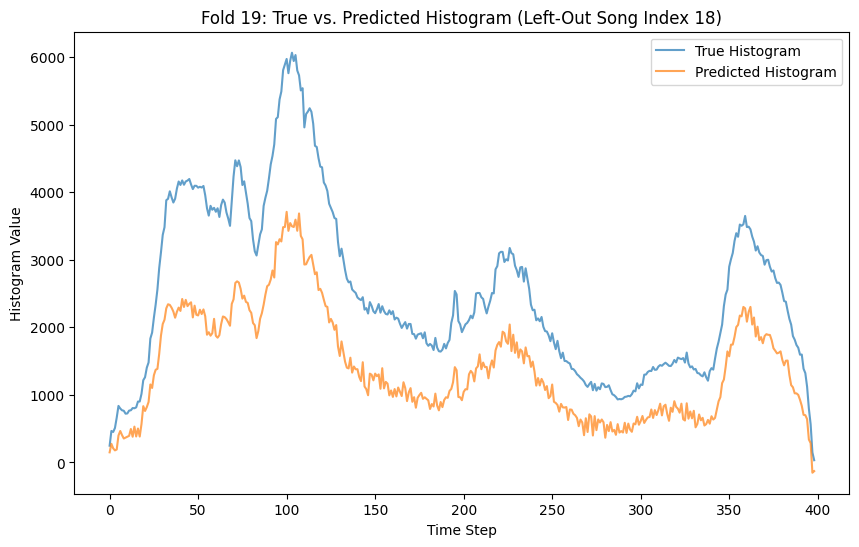

Fold 20: Leaving out song at index 19
Epoch 1/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step - loss: 107434.6250
Epoch 2/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 590ms/step - loss: 107008.6719
Epoch 3/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step - loss: 104788.2656
Epoch 4/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - loss: 106367.9688
Epoch 5/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 616ms/step - loss: 104524.7344
Epoch 6/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 562ms/step - loss: 108263.9922
Epoch 7/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 660ms/step - loss: 102275.4922
Epoch 8/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 479ms/step - loss: 108654.0938
Epoch 9/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 484ms/step - loss: 107155.9297
Epoch 10/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 526ms/step - loss: 103292.1094
Epoch 11/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step - loss: 103949.0000
Epoch 12/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step - loss: 103897.0391
Test MSE for this fold: 1550016.375
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Test RMSE for this fold: 1244.9964599609375


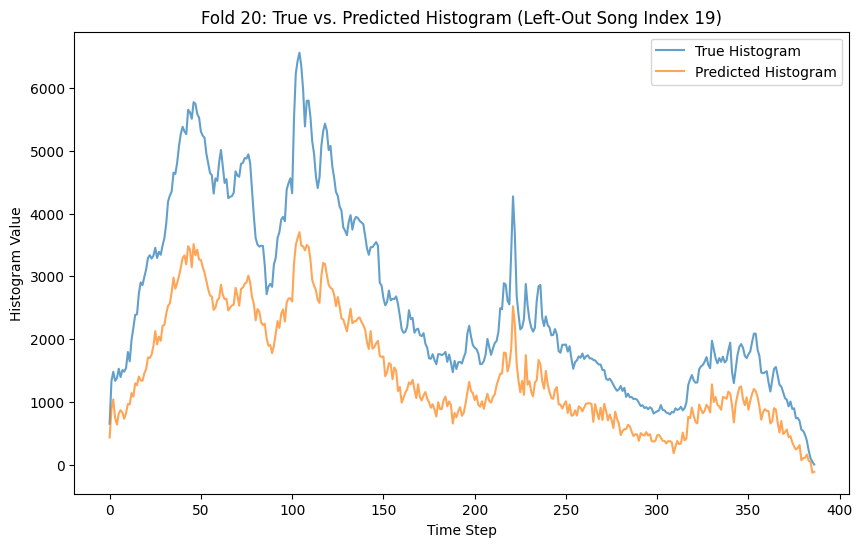

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import LeaveOneOut
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, Masking
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K

# Initialize Leave-One-Out cross-validator
loo = LeaveOneOut()

# Dynamically determine input shape from X
time_steps = X.shape[1]
features = X.shape[2]

# Custom masked loss function
def masked_mse(y_true, y_pred):
    mask = K.cast(K.not_equal(y_true, 0), K.floatx())  # Mask for non-zero values
    mse = K.square(y_pred - y_true) * mask             # Compute MSE only on non-zero values
    return K.sum(mse) / K.sum(mask)                    # Normalize by the number of non-zero values


model = Sequential()
model.add(Masking(mask_value=0., input_shape=(time_steps, features)))  # Mask zero-padded values
model.add(Conv1D(64, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.3))
model.add(Conv1D(128, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(time_steps, activation='linear'))
model.compile(optimizer=Adam(learning_rate=0.0001), loss=masked_mse)


for fold_number, (train_index, test_index) in enumerate(loo.split(X), start=1):

    print(f"Fold {fold_number}: Leaving out song at index {test_index[0]}")
    # Split the data into training and testing sets    X_train, X_test = X[train_index], X[test_index]
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    early_stopping = EarlyStopping(monitor='loss', patience=5)
    model.fit(X_train, y_train, epochs=30, batch_size=32, verbose=1, callbacks=[early_stopping])

    # Evaluate the model on the test set
    loss = model.evaluate(X_test, y_test, verbose=0)
    print(f"Test MSE for this fold: {loss}")

    # Make predictions
    y_pred = model.predict(X_test).flatten()

    # Calculate RMSE (mask padded values)
    valid_indices = y_test.flatten() != 0  # Exclude padded values
    rmse = np.sqrt(mean_squared_error(y_test.flatten()[valid_indices], y_pred[valid_indices]))
    print(f"Test RMSE for this fold: {rmse}")

    # Plot the true vs. predicted histograms
    plt.figure(figsize=(10, 6))
    plt.plot(y_test.flatten()[valid_indices], label='True Histogram', alpha=0.7)
    plt.plot(y_pred[valid_indices], label='Predicted Histogram', alpha=0.7)
    plt.xlabel('Time Step')
    plt.ylabel('Histogram Value')
    plt.title(f'Fold {fold_number}: True vs. Predicted Histogram (Left-Out Song Index {test_index[0]})')
    plt.legend()
    plt.show()
